# Problem Statement

Human Action Recognition (HAR) aims to identify human behavior. It has a wide range of applications, and therefore has been attracting increasing attention in the field of computer vision. Human actions can be represented using various data modalities, such as RGB, skeleton, depth, infrared, point cloud, event stream, audio, acceleration, radar, and WiFi signal, which encode different sources of useful yet distinct information and have various advantages depending on the application scenarios.


Consequently, lots of existing works have attempted to investigate different types of approaches for HAR using various modalities.


This project was just to build an Image Classification Model using CNN that classifies several human actions, turn this to a product service, using some MLOPs tools and observing industry best practices, as completion of the course - MLOPs Zoomcamp 2023 hosted by 
[DataTalksClub](https://www.linkedin.com/search/results/all/?fetchDeterministicClustersOnly=true&heroEntityKey=urn%3Ali%3Aorganization%3A71802369&keywords=datatalksclub&origin=RICH_QUERY_SUGGESTION&position=0&searchId=0157507a-27bf-439c-b717-8394da03a0fb&sid=6~t) 

### Importing library

In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd

import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm

from PIL import Image

from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt
import pickle
import uuid

# Overall Settings

In [5]:
FINE_TUNING_EPOCHS = 12 
TRAINING_EPOCHS = 5
BATCH_SIZE = 32

image_height = 180 
image_width = 300

# Load data

In [6]:
# path to the data files
train_path = "data/train"
test_path = "batch/test"

# Load data
test_df     = pd.read_csv("batch/Testing_set.csv")
training_df = pd.read_csv("data/Training_set.csv")

In [7]:
# Stratified Sampling
# Use groupby and apply to select sample 
# which maintains the population group ratios
valid_df = training_df.groupby('label').apply(lambda x: x.sample(frac=0.10))
# There is one problem though - groupby() has added island as an index. 
# Let’s drop the extra index using the Pandas__ method droplevel()__. Pass the parameter 0 as we want to drop the top level index.
valid_df = valid_df.droplevel(0)
# Creating dataframe with
# rest of the 90% values
train_df = training_df.drop(valid_df.index)

In [8]:
training_df.head()

filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop

In [9]:
freq = training_df['label'].value_counts()
train_freq = train_df['label'].value_counts()
valid_freq = valid_df['label'].value_counts()

print(freq,"\n\n", train_freq,"\n\n",valid_freq)
print()

label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64 

 label
sitting               756
hugging               756
sleeping              756
using_laptop          756
clapping              756
dancing               756
cycling               756
drinking              756
calling               756
laughing              756
eating                756
fighting              756
listening_to_music    756
running               756
texting               756
Name: count, dtype: int64 

 label
calling               84
clapping              84
cycling               84
dancing               84
drinking              84
eating             

In [10]:
test_df.head()

filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

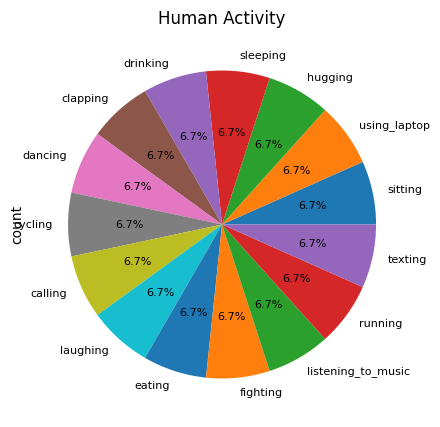

In [11]:
freq.plot(kind='pie',figsize=(5,5),title='Human Activity',autopct='%1.1f%%',shadow = False,  fontsize=8);

# Data Generators

In [12]:
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

In [13]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = True,
                         vertical_flip   = False,
                         zoom_range      = 0.05,
                         rotation_range  = 25)
 
train_generator = gen.flow_from_dataframe(
    train_df, # dataframe
    directory = train_path , # images data path / folder in which images are there
    x_col = 'filename',
    y_col = 'label',
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 11340 validated image filenames belonging to 15 classes.


In [ ]:
# Data agumentation and pre-processing using tensorflow
test_gen = ImageDataGenerator(rescale = 1./255.)

validation_generator = test_gen.flow_from_dataframe(
    valid_df, # dataframe
    directory   = test_path, # images data path / folder in which images are there
    x_col       = 'filename',
    y_col       = 'label',
    color_mode  ="rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    seed        = 42)

test_generator = test_gen.flow_from_dataframe(
    test_df, # dataframe
    directory   = test_path, # images data path / folder in which images are there
    x_col       = 'filename',
    #y_col       = 'labels',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = None,
    batch_size  = BATCH_SIZE,
    shuffle  = False)

In [15]:
# Get labels in dataset
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list

In [16]:
class_names

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

In [17]:
# Define function to plot some images
import matplotlib.pyplot as plt

def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            if true_labels is not None:
                plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
            else:
                plt.title("{} {:.1f}%".format(class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i]))) 
        else:
            if true_labels is not None:
                plt.title(class_names[np.argmax(true_labels[i])])    

# Sample Images

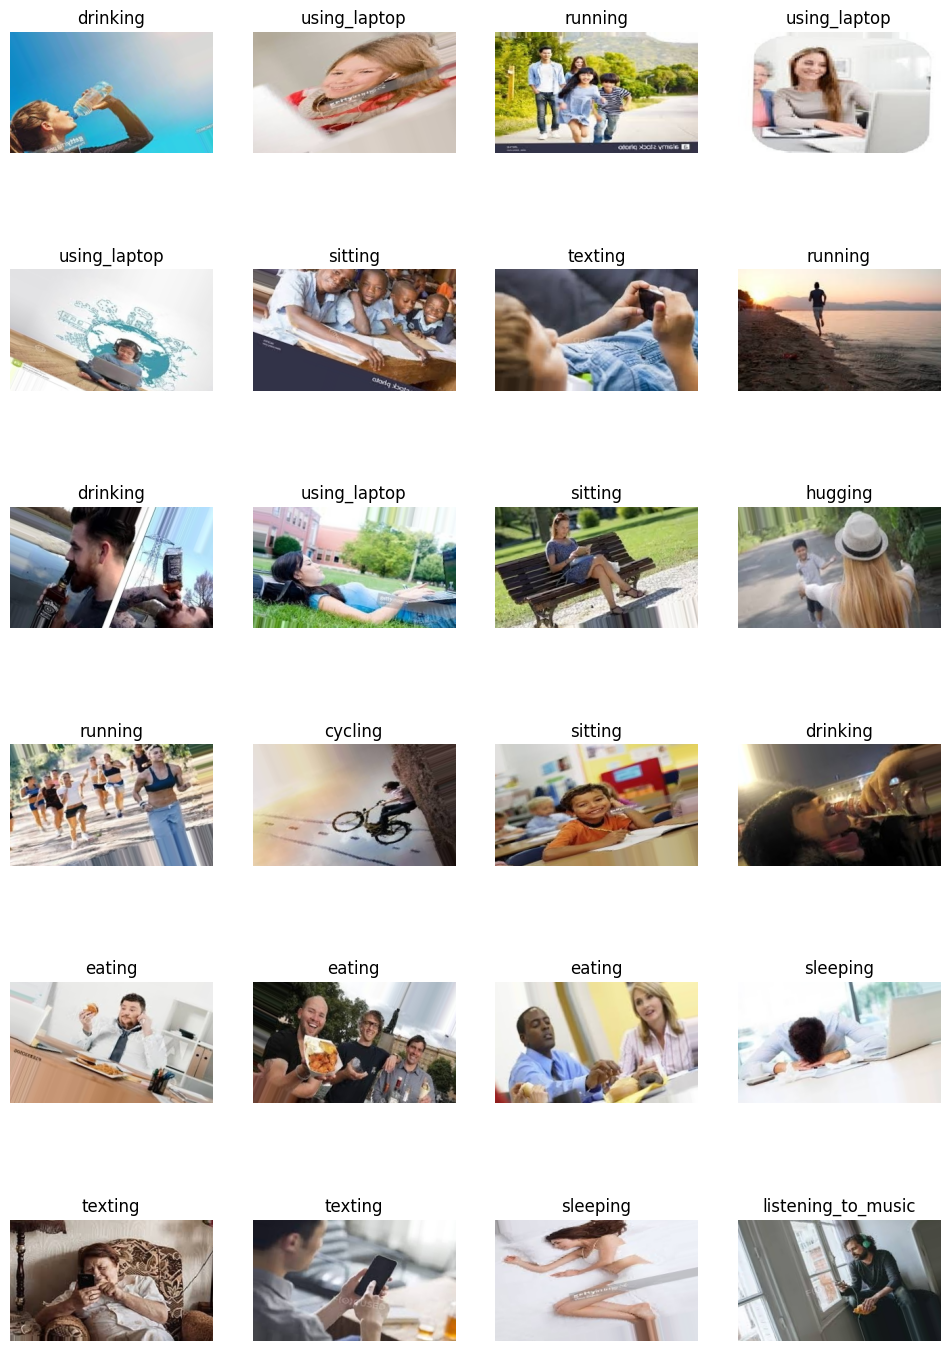

In [18]:
x,y = next(train_generator)
plot_images(x,y)

In [19]:
# function to plot training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    ax.set_title(title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

# Grad-Cam

In [21]:
from matplotlib import cm

def make_gradcam_heatmap(image, model, last_conv_layer_name):
 
    img_array = tf.expand_dims(image, axis=0)
    
    # Remove last layer's softmax
    last_layer_activation = model.layers[-1].activation
    model.layers[-1].activation = None

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()  
    
    
     # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array[0].shape[1], img_array[0].shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img_array[0] * 255 

    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    # Restore last layer activation
    model.layers[-1].activation = last_layer_activation
    
    return superimposed_img

# Model

In [22]:
from tensorflow.keras.models import Model

def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model  

In [23]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    # early stopping call back
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
       
    # categorical cross entropy is taken since its used as a loss function for
    # multi-class classification problems where there are two or more output labels.
    # using Adam optimizer for better performance
    # other optimizers such as sgd can also be used depending upon the model

    # fit model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early])
    
    return history

# VGG16

In [25]:
# load the VGG16 architecture with imagenet weights as base
vgg16_base_model = tf.keras.applications.vgg16.VGG16(
                             include_top = False,
                             weights = 'imagenet',
                             input_shape = (image_height, image_width, 3)
                             )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
vgg16_model = create_model(vgg16_base_model)
#vgg16_model.summary()
history = fit_model(vgg16_model, vgg16_base_model, epochs = TRAINING_EPOCHS)

Unfreezing number of layers in base model =  0
Epoch 1/5
355/355 [==============================] - 13780s 39s/step - loss: 2.4600 - accuracy: 0.1825 - val_loss: 3.1621 - val_accuracy: 0.0611
Epoch 2/5
355/355 [==============================] - 3762s 11s/step - loss: 2.0949 - accuracy: 0.2966 - val_loss: 3.6812 - val_accuracy: 0.0646
Epoch 3/5
355/355 [==============================] - 3736s 11s/step - loss: 1.9739 - accuracy: 0.3422 - val_loss: 3.9298 - val_accuracy: 0.0628
Epoch 4/5
355/355 [==============================] - 3740s 11s/step - loss: 1.9229 - accuracy: 0.3630 - val_loss: 4.0770 - val_accuracy: 0.0558
Epoch 5/5
355/355 [==============================] - 3850s 11s/step - loss: 1.8630 - accuracy: 0.3785 - val_loss: 4.0623 - val_accuracy: 0.0611


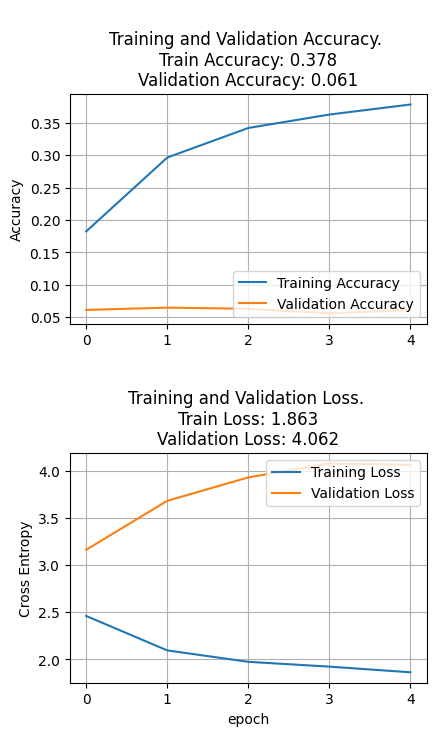

In [27]:
plot_history(history)

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
nr_base_layers = len(vgg16_base_model.layers)
print("VGG16 base layers = ", nr_base_layers)    

history = fit_model(vgg16_model, vgg16_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

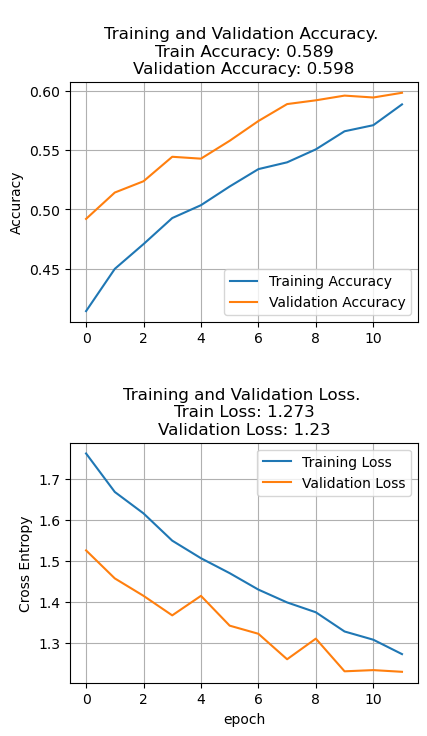

In [ ]:
plot_history(history)

In [ ]:
accuracy_score = vgg16_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
validation_generator.reset()

vgg16_val_preds = vgg16_model.predict(validation_generator)
vgg16_val_pred_classes = np.argmax(vgg16_val_preds, axis=1)

40/40 [==============================] - 3s 78ms/step


In [35]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

vgg16_test_preds = vgg16_model.predict(test_generator)
vgg16_test_pred_classes = np.argmax(vgg16_test_preds, axis=1)

169/169 [==============================] - 1676s 10s/step


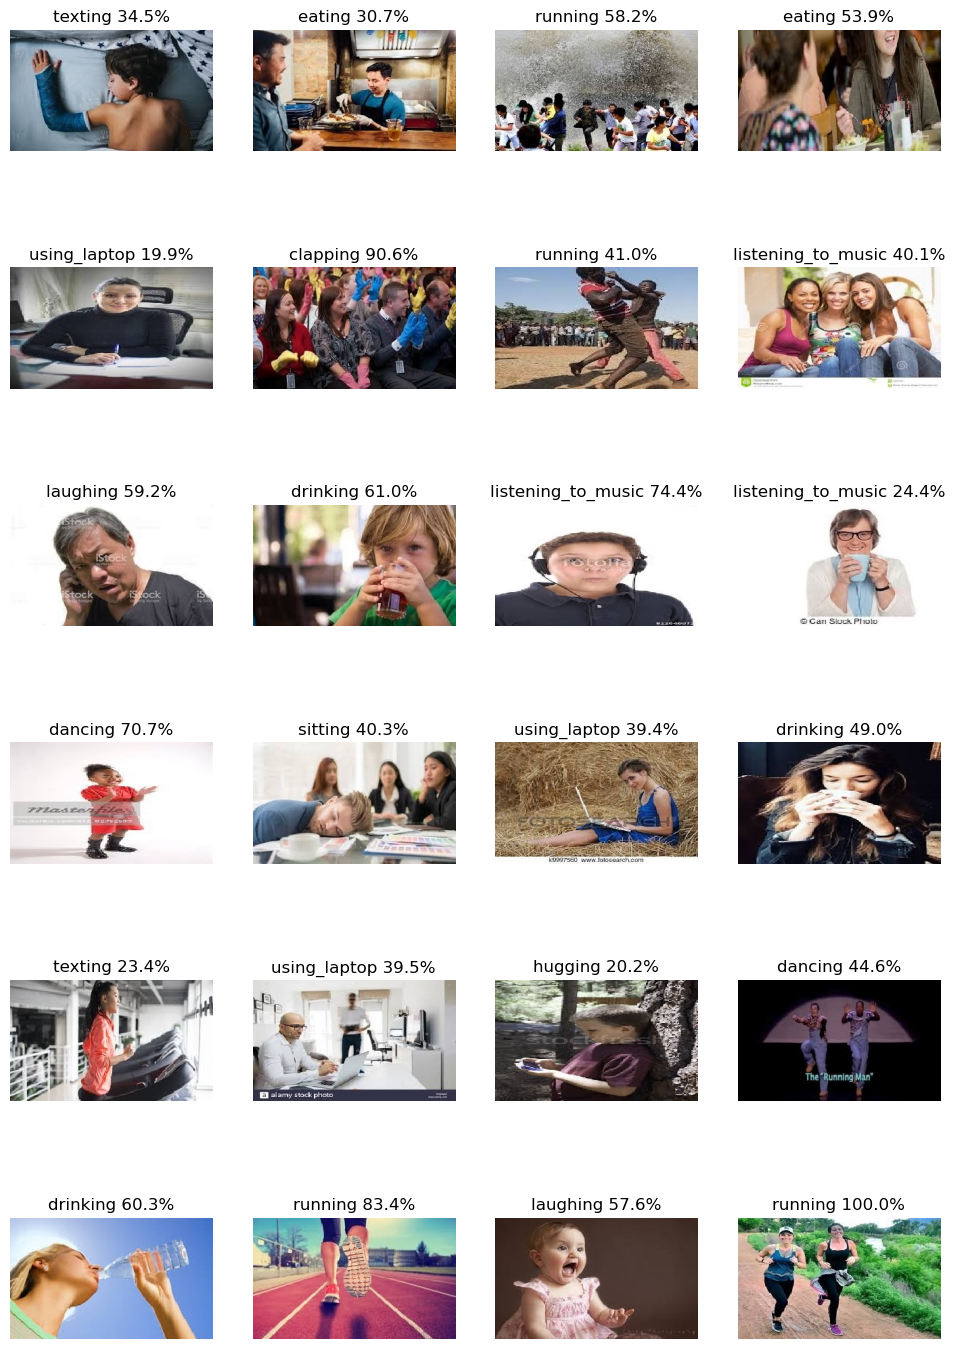

In [ ]:
test_generator.reset()
x = next(test_generator)
plot_images(x, None, vgg16_test_preds)

/tmp/ipykernel_23/546683909.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


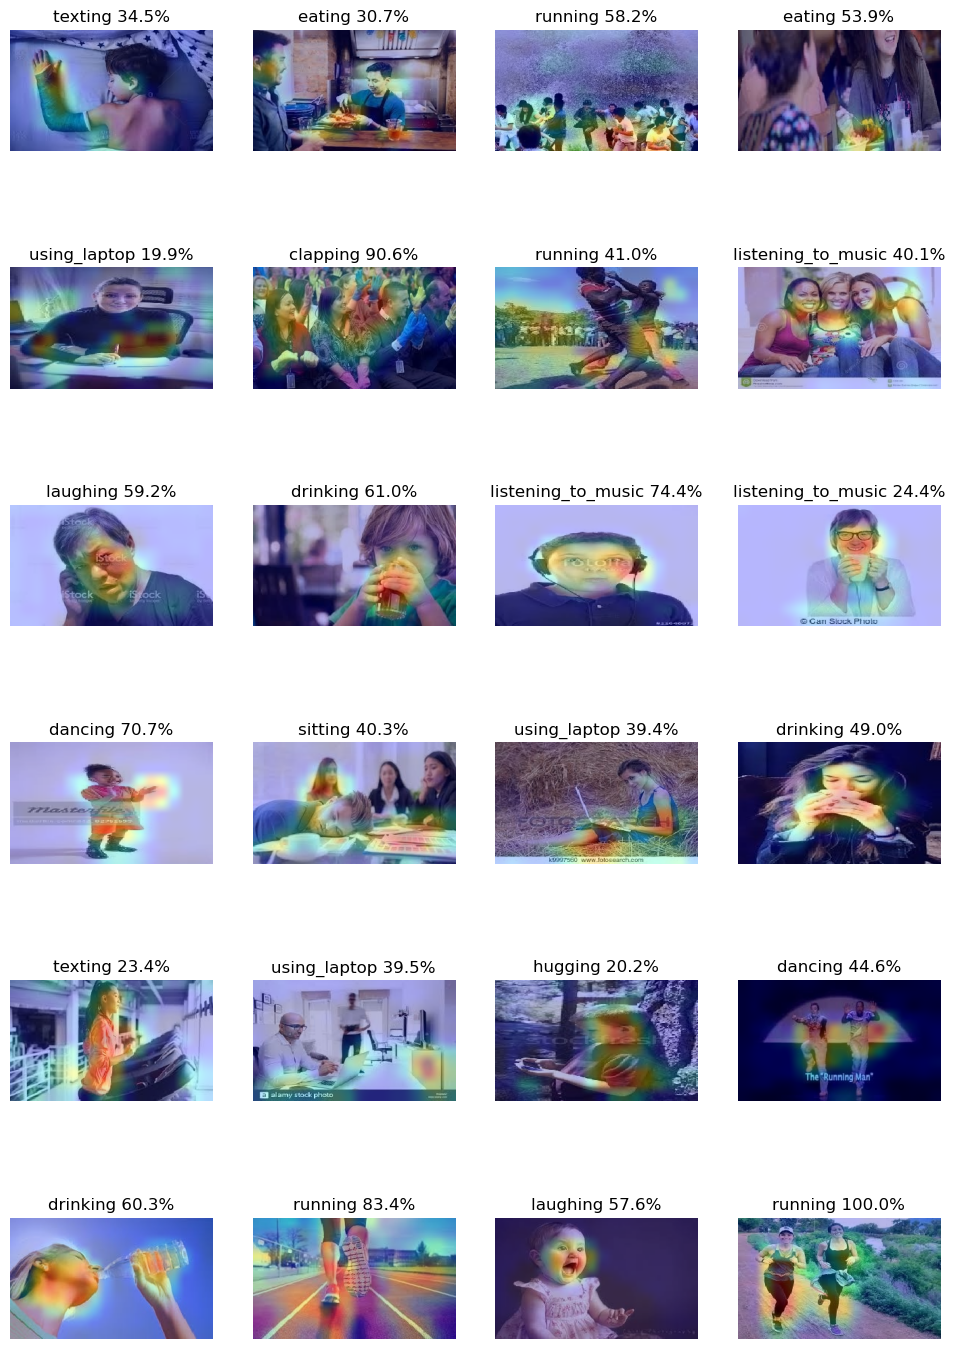

In [ ]:
last_conv_layer_name = "block5_conv3"

heatmaps =[]

for img in x:
    heatmap = make_gradcam_heatmap(img, vgg16_model, last_conv_layer_name)
    heatmaps.append(heatmap)
    
plot_images(heatmaps, None, vgg16_test_preds)

# Confusion Matrix

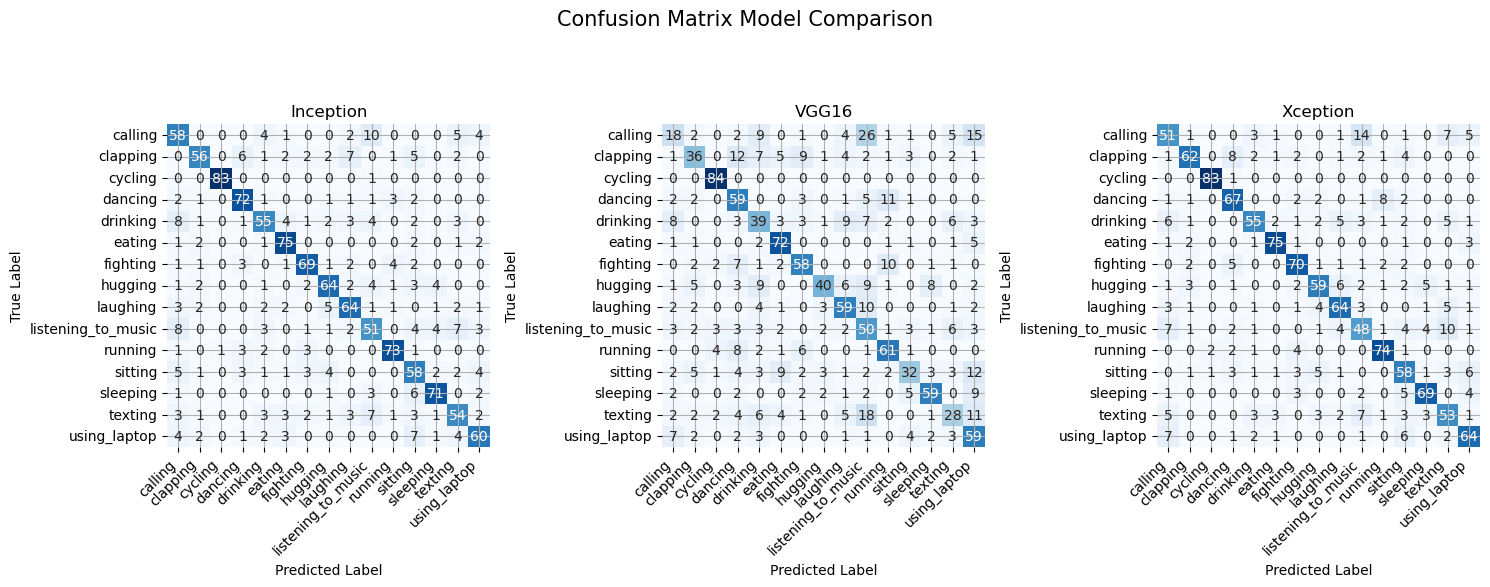

In [ ]:
# Display confusion matrix
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

true_classes = validation_generator.classes

plot_heatmap(true_classes, inception_val_pred_classes, class_names, ax1, title = "Inception")    
plot_heatmap(true_classes, vgg16_val_pred_classes, class_names, ax2, title = "VGG16")    
    

fig.suptitle("Confusion Matrix Model Comparison", fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [36]:

#model = vgg_model.load_weights("HARmodel_main.h5")
# Save the model as pickle
#import pickle
#with open("model.bin", "wb") as f_in:
   # pickle.dump(vgg16_model, f_in)


In [37]:
vgg16_model.save("HARmodel.h5")